In [169]:
# Imports
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
import random
np.random.seed(1)  
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD
from sklearn import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.utils import plot_model

# from tensorflow import set_random_seed
np.random.seed(1)

# imports from file
from Functions.Data_mod.Data_load    import * 
from Functions.Data_mod.Data_filters import *
from Functions.Data_mod.Data_parser  import *
from Functions.Data_mod.Data_plot    import *

%matplotlib inline


def norm_by_column(data):
    mins=np.min(data, axis=0)
    maxs=np.max(data, axis=0)
    data=(data-mins)/(maxs-mins)
    return data, mins, maxs


def denorm_by_column(data, mins, maxs):
    return data*(maxs-mins)+mins

In [170]:
# ========= Settings ========================
random.seed(30)
# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'
# Display all columns with pd.head()
pd.set_option('display.max_columns', 50)

In [171]:
# Load in the measurement data
#============= Load file =====================================================
folder = 'Day_03'
date_train = '2019_ 11_ 11_16_25_19_'

df_train = Data_mod_Load(folder, date_train)
df_train_filtered = Data_mod_Filter(df_train, scale=0, qFilter='False', drop='True')


In [181]:

#=============================================================================
# Parsing data
epochs     = 20
n_steps    = 64
features   = 10
output_num = -3 # -1=dz, -8=z # Tracked is present -10=z -3=dz ha drop true
normed_data, mins, maxs=norm_by_column(np.array(df_train_filtered))
X, Y = split_sequences(normed_data, n_steps, features=features, output_num = output_num)

X_train = X[0:int(len(X)*0.6),:,:]
Y_train = Y[0:int(len(Y)*0.6)]
X_valid = X[int(len(X)*0.6):int(len(X)*0.7),:,:]
Y_valid = Y[int(len(Y)*0.6):int(len(Y)*0.7)]
X_test  = X[int(len(X)*0.75):,:,:]
Y_test  = Y[int(len(Y)*0.75):]

'''
plt.plot(Y_test, color = 'red', label='Y-test')
plt.xlabel("Iteration [-]")
plt.ylabel("Position [m]")
plt.legend()
plt.show()
'''

'\nplt.plot(Y_test, color = \'red\', label=\'Y-test\')\nplt.xlabel("Iteration [-]")\nplt.ylabel("Position [m]")\nplt.legend()\nplt.show()\n'

In [188]:
#===== Neural Network Modell ================================================

# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]

model = Sequential()

#model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
#model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2,strides=2))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.5))
#model.add(MaxPooling1D(pool_size=2,strides=2))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2,strides=2))

#model.add(Flatten())
#model.add(TimeDistributed(Flatten()))

model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(LSTM(8, activation='relu', return_sequences=False))
#model.add(LSTM(16, activation='relu', return_sequences=False))
#model.add(LSTM(8,  activation='relu', return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(4, activation='relu', return_sequences=False))

#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
#model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')#SGD(lr=1e-3,momentum=0.9), loss='mse')

Train on 30925 samples, validate on 5155 samples
Epoch 1/4
30925/30925 - 61s - loss: 0.0325 - val_loss: 5.7123e-04
Epoch 2/4
30925/30925 - 56s - loss: 0.0055 - val_loss: 6.0224e-04
Epoch 3/4
30925/30925 - 56s - loss: 0.0051 - val_loss: 5.2231e-04
Epoch 4/4
30925/30925 - 56s - loss: 0.0049 - val_loss: 0.0014


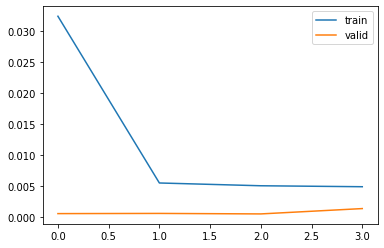

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_128 (Conv1D)          (None, 62, 128)           3968      
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 60, 128)           49280     
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 28, 64)            24640     
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 26, 64)            12352     
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 13, 64)            0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 13, 32)          

In [189]:


#=============================================================================

# fit model
with tf.device('/GPU:0'):
    history=model.fit(X_train, Y_train, 
              epochs=4,
              validation_data=(X_valid, Y_valid),
              batch_size=512,
              verbose=2)
              #shuffle= True)


    plt.plot(history.history['loss'],     label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.show()

    model.summary()


In [192]:

# ======== Save model ========================
# save model and architecture to single file
model.save("08_Linear_Network_weights.hdf5")

#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#model.load_weights("08_Linear_Network_weights.hdf5")
with tf.device('/GPU:0'):
    Y_pred = model.predict(X_test, verbose=2)



12886/1 - 14s


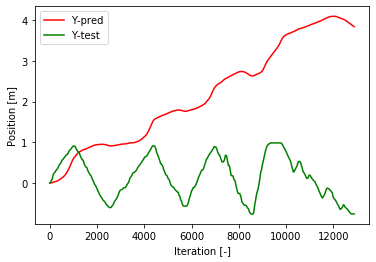

In [193]:
plt.plot(np.cumsum(denorm_by_column(Y_pred,mins[output_num],maxs[output_num])), color = 'red', label='Y-pred')
plt.plot(np.cumsum(denorm_by_column(Y_test,mins[output_num],maxs[output_num])), color = 'green', label='Y-test')
plt.xlabel("Iteration [-]")
plt.ylabel("Position [m]")
plt.legend()
plt.show()

In [177]:
X_train

array([[[0.28125001, 0.44341085, 0.57104677, ..., 0.44322344,
         0.76683938, 0.        ],
        [0.34375   , 0.44341085, 0.57104677, ..., 0.25274725,
         0.32642487, 0.67647059],
        [0.4375    , 0.44341085, 0.5714922 , ..., 0.25274725,
         0.32642487, 0.67647059],
        ...,
        [0.3125    , 0.44418605, 0.57104677, ..., 0.25274725,
         0.32642487, 0.69411765],
        [0.3125    , 0.44341085, 0.5714922 , ..., 0.44322344,
         0.76683938, 0.        ],
        [0.31250001, 0.44341085, 0.57104677, ..., 0.44322344,
         0.76683938, 0.        ]],

       [[0.34375   , 0.44341085, 0.57104677, ..., 0.25274725,
         0.32642487, 0.67647059],
        [0.4375    , 0.44341085, 0.5714922 , ..., 0.25274725,
         0.32642487, 0.67647059],
        [0.78125   , 0.44341085, 0.5714922 , ..., 0.25274725,
         0.34196891, 0.67647059],
        ...,
        [0.3125    , 0.44341085, 0.5714922 , ..., 0.44322344,
         0.76683938, 0.        ],
        [0.3

In [178]:
X_test.shape

(12870, 128, 10)

In [179]:
np.array(df_train_filtered)

array([[ 8.90000002e-03,  2.60000000e-02, -3.00000000e-02, ...,
         1.05000000e-04,  1.50000000e-04, -2.05000000e-04],
       [ 9.10000000e-03,  2.60000000e-02, -3.00000000e-02, ...,
        -9.40000000e-05, -2.48000000e-04,  3.46000000e-04],
       [ 9.39999998e-03,  2.60000000e-02, -2.90000000e-02, ...,
         1.12000000e-04,  2.64000000e-04, -3.28000000e-04],
       ...,
       [ 8.99999999e-03,  2.10000000e-02, -6.00000000e-03, ...,
         3.00000000e-06, -1.50000000e-05,  2.00000000e-06],
       [ 8.99999999e-03,  2.00000000e-02, -6.00000000e-03, ...,
         4.10000000e-05,  7.10000000e-05, -4.50000000e-05],
       [ 9.00000002e-03,  2.00000000e-02, -6.00000000e-03, ...,
         3.00000000e-06, -4.00000000e-05,  2.50000000e-05]])

In [180]:
df_train_filtered.head()

,DeltaT,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,x,y,z,Qx,Qy,Qz,Qw,dx,dy,dz
0,0.0089,0.026,-0.030,1.028,-0.463,0.443,-0.188,0.000,0.000,0.000,0.866311,0.474722,0.628969,0.004834,-0.002874,0.014492,-0.999879,0.000105,0.000150,-0.000205
1,0.0091,0.026,-0.030,1.028,-0.222,0.322,-0.054,-0.052,-0.085,0.115,0.866217,0.474474,0.629315,0.001788,-0.002164,0.013382,-0.999907,-0.000094,-0.000248,0.000346
2,0.0094,0.026,-0.029,1.029,-0.423,0.504,-0.013,-0.052,-0.085,0.115,0.866329,0.474738,0.628987,0.004934,-0.002566,0.014086,-0.999885,0.000112,0.000264,-0.000328
3,0.0105,0.026,-0.029,1.028,-0.342,0.342,-0.067,-0.052,-0.082,0.115,0.866212,0.474648,0.629121,-0.000997,-0.001909,0.016751,-0.999857,-0.000117,-0.000090,0.000134
4,0.0105,0.027,-0.030,1.028,-0.665,0.262,-0.081,0.000,0.000,0.000,0.866276,0.474744,0.629037,0.005088,-0.002374,0.014018,-0.999886,0.000064,0.000096,-0.000084
